# CNNの実装
PyTorchを使って、畳み込みニューラルネットワーク（CNN）を実装します。  
CNN自体はCNNの層を追加するのみで実装可能なのですが、今回はデータ拡張とドロップアウトの実装も行います。


## CIFAR-10
torchvision.datasetsを使い、CIFAR-10を読み込みます。  
CIFARは、約6万枚の画像にラベルをつけたたデータセットです。  
以下のコードでは、CIFAR-10を読み込み、ランダムな25枚の画像を表示します。

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
データの数: 10000


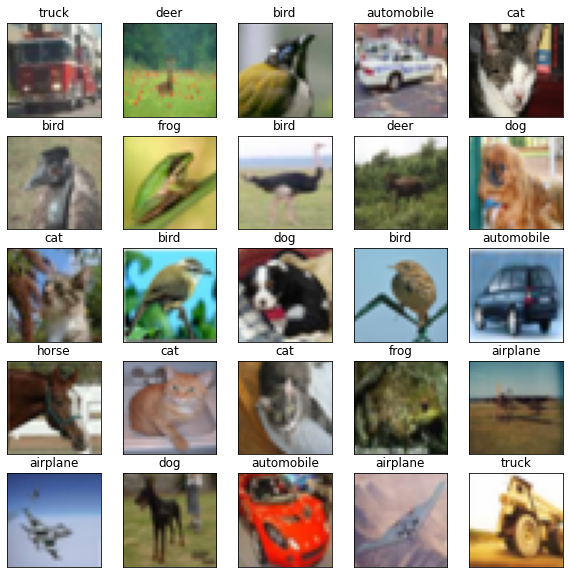

In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms#画像を変換するためのモジュール
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

cifar10_data = CIFAR10(root="./data",
                       train=False,download=True,
                       transform=transforms.ToTensor())#テスト用のデータとして読み込む
cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer",
                            "dog", "frog", "horse", "ship", "truck"])
print("データの数:", len(cifar10_data))

n_image = 25  # 表示する画像の数
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)#バッチサイズが25枚
dataiter = iter(cifar10_loader)  # イテレータ
images, labels = dataiter.next()  # 最初のバッチを取り出す

plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(n_image):
    plt.subplot(5,5,i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))  # チャンネルを一番後ろに
    label = cifar10_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

## データ拡張
torchvision.transformsを使ってデータ拡張を行います。  
今回は、cifar-10の画像に-30〜30°の回転、および0.8〜1.2倍のリサイズを行います。  
これらの処理は、バッチを取り出す際に元の画像に対してランダムに加えられます。    


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
データの数: 10000


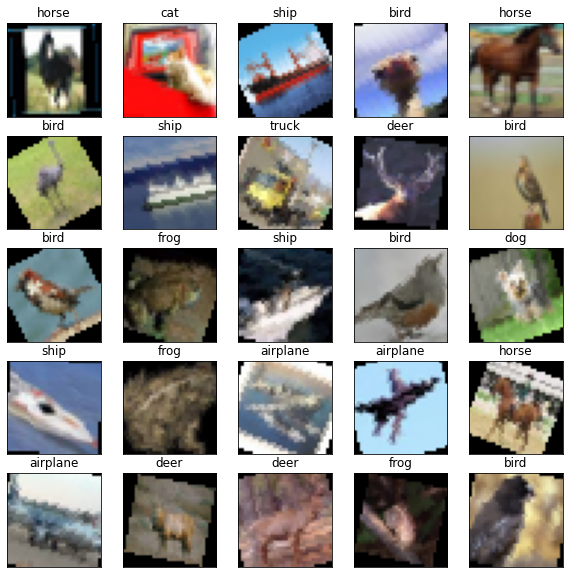

In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.RandomAffine([-30, 30], scale=(0.8, 1.2)),  # 回転とリサイズ
                                transforms.ToTensor()])
cifar10_data = CIFAR10(root="./data",
                       train=False,download=True,
                       transform=transform)
cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer",
                            "dog", "frog", "horse", "ship", "truck"])
print("データの数:", len(cifar10_data))

n_image = 25  # 表示する画像の数
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)
dataiter = iter(cifar10_loader)  # イテレータ
images, labels = dataiter.next()  # 最初のバッチを取り出す→ここでデータ拡張がランダムに加えられる

plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(n_image):
    plt.subplot(5,5,i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))  # チャンネルを一番後ろに
    label = cifar10_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

## データの前処理
ここからCNNを実装します。  
データ拡張として、回転とリサイズ、および左右反転を行います。  
また、学習が効率的になるように入力の平均値を0、標準偏差を1にします（標準化）。  
DataLoaderは、訓練データ、テストデータそれぞれで設定しますが、テストデータにはミニバッチ法を適用しないのでバッチサイズは元データのサンプル数にします。

In [2]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2))  # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転(p=0.5はは50%の確率で左右反転を行う)
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に→RGBそれぞれに対して行う
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## モデルの構築
`nn.Module`モジュールを継承したクラスとして、モデルを構築します。  
今回は、過学習を抑制するためにドロップアウトを導入します。  

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)→出力画像のサイズは、32-5+1=28
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, ストライド→出力画像のサイズは、、28÷2=14
        self.conv2 = nn.Conv2d(6, 16, 5)　#畳み込み層→フィルタ数がが16だからこの出力はチャンネル数が16となる、サイズはは14-5+1=10となる
        self.fc1 = nn.Linear(16*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))#→この時点で出力画像は出力画像は5✖️5
        x = x.view(-1, 16*5*5) #一次元に直す
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  
今回は、評価時にミニバッチ法は使わず、テストデータ全体を使って一度に誤差を計算します。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。


In [4]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
x_test, t_test = iter(test_loader).next()
x_test, t_test = x_test.cuda(), t_test.cuda()
for i in range(20):  # 20エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    y_test = net(x_test)
    loss_test = loss_fnc(y_test, t_test).item()
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0 Loss_Train: 1.7966468721399527 Loss_Test: 1.5501679182052612
Epoch: 1 Loss_Train: 1.5752925901766628 Loss_Test: 1.4141814708709717
Epoch: 2 Loss_Train: 1.4915911035464549 Loss_Test: 1.358294129371643
Epoch: 3 Loss_Train: 1.4324437318860417 Loss_Test: 1.312881588935852
Epoch: 4 Loss_Train: 1.3956385038392929 Loss_Test: 1.2695565223693848
Epoch: 5 Loss_Train: 1.3621846505290711 Loss_Test: 1.2180237770080566
Epoch: 6 Loss_Train: 1.3359193153241102 Loss_Test: 1.2007999420166016
Epoch: 7 Loss_Train: 1.3179975539979423 Loss_Test: 1.1860321760177612
Epoch: 8 Loss_Train: 1.291742205314929 Loss_Test: 1.2361586093902588
Epoch: 9 Loss_Train: 1.2845089307526494 Loss_Test: 1.1874313354492188
Epoch: 10 Loss_Train: 1.2758310910533457 Loss_Test: 1.212493658065796
Epoch: 11 Loss_Train: 1.2628506778756066 Loss_Test: 1.1593830585479736
Epoch: 12 Loss_Train: 1.2415017426928596 Loss_Test: 1.1412004232406616
Epoch: 13 Loss_Train: 1.2442390066583444 Loss_Test: 1.1092585325241089
Epoch: 14 Loss_Train

## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

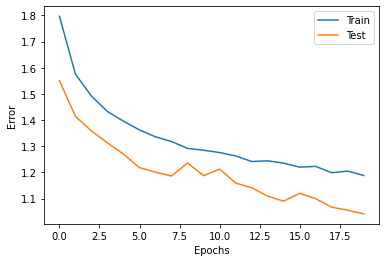

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [6]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 63.43%


## 訓練済みのモデルを使った予測
訓練済みのモデルを使ってみましょう。  
画像を入力し、モデルが機能していることを確かめます。

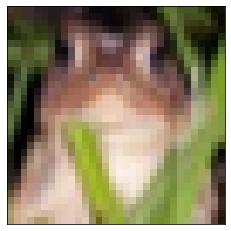

正解: frog 予測結果: dog


In [8]:
cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = dataiter.next()  # サンプルを1つだけ取り出す

plt.imshow(np.transpose(images[0], (1, 2, 0)))  # チャンネルを一番後ろに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

net.eval()  # 評価モード
x, t = images.cuda(), labels.cuda()  # GPU対応
y = net(x)
print("正解:", cifar10_classes[labels[0]],
      "予測結果:", cifar10_classes[y.argmax().item()])